In [1]:
from google.colab import files

In [2]:
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from tensorflow.keras.preprocessing.text import Tokenizer
import datetime
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import gensim
import smart_open
from string import punctuation
stop_words = stopwords.words('english')
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Lambda
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint,Callback
from tensorflow.keras.layers import Input, Bidirectional, LSTM, dot, Flatten, Dense, Reshape, add, Dropout, BatchNormalization

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
uploaded = files.upload()

Saving QuoraData.zip to QuoraData.zip


In [20]:
MAX_SEQUENCE_LENGTH = 100
SENT_EMBEDDING_DIM = 128
WORD_EMBEDDING_DIM = 300
NB_EPOCHS = 25
DROPOUT = 0.2
BATCH_SIZE = 516
VALIDATION_SPLIT = 0.1

In [19]:
MODEL_WEIGHTS_FILE = 'question_pairs_weights.h5'

In [4]:
import zipfile

In [5]:
!unzip /content/QuoraData.zip

Archive:  /content/QuoraData.zip
  inflating: label_train.npy         
  inflating: q1_train.npy            
  inflating: q2_train.npy            
  inflating: word_embedding_matrix.npy  


In [6]:
Q1_TRAINING_DATA_FILE = 'q1_train.npy'
Q2_TRAINING_DATA_FILE = 'q2_train.npy'
LABEL_TRAINING_DATA_FILE = 'label_train.npy'
WORD_EMBEDDING_MATRIX_FILE = 'word_embedding_matrix.npy'

q1_data = np.load(open(Q1_TRAINING_DATA_FILE, 'rb'))
q2_data = np.load(open(Q2_TRAINING_DATA_FILE, 'rb'))
labels = np.load(open(LABEL_TRAINING_DATA_FILE, 'rb'))
word_embedding_matrix = np.load(open(WORD_EMBEDDING_MATRIX_FILE, 'rb'))


In [7]:
q1_data.shape

(404290, 100)

In [8]:
q2_data.shape

(404290, 100)

In [9]:
labels.shape

(404290,)

In [10]:
word_embedding_matrix.shape

(116886, 300)

In [13]:
len(word_embedding_matrix)

116886

In [11]:
X = np.stack((q1_data, q2_data), axis=1)
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13371447)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]

In [21]:
y_train.shape

(363861,)

In [17]:
question1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
question2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

q1 = Embedding(len(word_embedding_matrix), 
                 WORD_EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question1)
q1 = Bidirectional(LSTM(SENT_EMBEDDING_DIM, return_sequences=True), merge_mode="sum")(q1)

q2 = Embedding(len(word_embedding_matrix), 
                 WORD_EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question2)
q2 = Bidirectional(LSTM(SENT_EMBEDDING_DIM, return_sequences=True), merge_mode="sum")(q2)

attention = dot([q1,q2], [1,1])
attention = Flatten()(attention)
attention = Dense((MAX_SEQUENCE_LENGTH*SENT_EMBEDDING_DIM))(attention)
attention = Reshape((MAX_SEQUENCE_LENGTH, SENT_EMBEDDING_DIM))(attention)

merged = add([q1,attention])
merged = Flatten()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

is_duplicate = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[question1,question2], outputs=is_duplicate)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 300)     35065800    input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 100, 300)     35065800    input_4[0][0]                    
______________________________________________________________________________________________

In [24]:
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE,monitor='val_accuracy', save_best_only=True,mode='max')]
history = model.fit([Q1_train, Q2_train],
                    y_train,
                    epochs=NB_EPOCHS,
                    validation_split=VALIDATION_SPLIT,
                    verbose=2,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks)  

Epoch 1/25
635/635 - 435s - loss: 0.3318 - accuracy: 0.8469 - val_loss: 0.4749 - val_accuracy: 0.7617
Epoch 2/25
635/635 - 433s - loss: 0.2939 - accuracy: 0.8674 - val_loss: 0.4413 - val_accuracy: 0.8033
Epoch 3/25
635/635 - 436s - loss: 0.2609 - accuracy: 0.8844 - val_loss: 0.4527 - val_accuracy: 0.8108
Epoch 4/25
635/635 - 436s - loss: 0.2315 - accuracy: 0.8994 - val_loss: 0.4719 - val_accuracy: 0.8092
Epoch 5/25
635/635 - 435s - loss: 0.2035 - accuracy: 0.9127 - val_loss: 0.4820 - val_accuracy: 0.8125
Epoch 6/25
635/635 - 433s - loss: 0.1770 - accuracy: 0.9260 - val_loss: 0.5152 - val_accuracy: 0.8123
Epoch 7/25
635/635 - 433s - loss: 0.1561 - accuracy: 0.9355 - val_loss: 0.5379 - val_accuracy: 0.8122
Epoch 8/25
635/635 - 434s - loss: 0.1359 - accuracy: 0.9441 - val_loss: 0.6077 - val_accuracy: 0.8137
Epoch 9/25
635/635 - 435s - loss: 0.1191 - accuracy: 0.9519 - val_loss: 0.6043 - val_accuracy: 0.8160
Epoch 10/25
635/635 - 436s - loss: 0.1062 - accuracy: 0.9578 - val_loss: 0.6425 - 

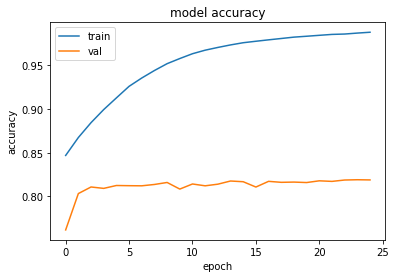

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
from google.colab import files
files.download("question_pairs_weights.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
1+2

3